# Project: Navigation

---

This is the first project of Udacity Deep Learning Nanodegree. I developed a **Double Deep Q-Learning (DDQN)** Agent which moves in Unity game engine Environment in banana catching game. 
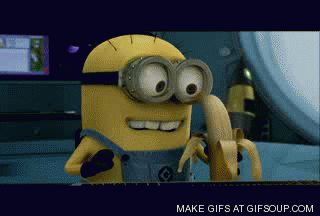

### 1. Start the Environment

Run the next code cell to install a few packages. This line will take a few minutes to run! This cell is online required in the Udacity Workspace.

In [2]:
!pip -q install ./python
!pip install collections # included during testing might need to remove

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [3]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque

Below code again is for running this in Udacity Workspace. If you are using in your local development space change the file location that matches your system.


In [4]:
# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Double Deep Q-Learning (DDQN)Agent

After a brief research, I selected my model as DDQN as my agent as it has better performance than DQN.

The selected parameters are as below:
- ``hidden_layers`` (list of int)
    - Specify the structure of Neural Network (In: state, Out: estimated reward of each action)
    - If you set ``[64, 32]``:
        - Input : state
        - Hidden Layer 1 : 64 nodes
        - Hidden Layer 2 : 32 nodes
        - Output : estimated reward of each action
        
- ``learning_rate`` (float)
    - learning rate for Adam.
    
- ``tau`` (float between 0 and 1)
    - slower if smaller value


In [6]:
from dqn import DDQNAgent
agent = DDQNAgent(state_size=state_size, action_size=action_size, seed=123,
                  hidden_layers=[32, 8], tau=1e-3, learning_rate=5e-4)

Before you train the agent, check how it performs in the simulation ***without training***.  
You can see that it makes almost random decision.

In [7]:
# reset environment
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]

# run without training
for j in range(20):
    # select action
    action = agent.act(state).astype(int)
    env_info = env.step(action)[brain_name]
    
    # get the next state
    state = env_info.vector_observations[0]
    # get the reward
    reward = env_info.rewards[0]
    # see if episode has finished
    done = env_info.local_done[0]
    if done:
        break 

### 4. Training

In [9]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train Agent by playing simulator
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]   # get the next state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [10]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
scores = train()

Episode 100	Average Score: 0.60
Episode 200	Average Score: 4.03
Episode 300	Average Score: 8.28
Episode 400	Average Score: 9.87
Episode 500	Average Score: 11.75
Episode 555	Average Score: 13.09
Environment solved in 455 episodes!	Average Score: 13.09


### 5. Check score history
Plot the time series of scores during training.
Plotted figure is save to `result_score.jpg`

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

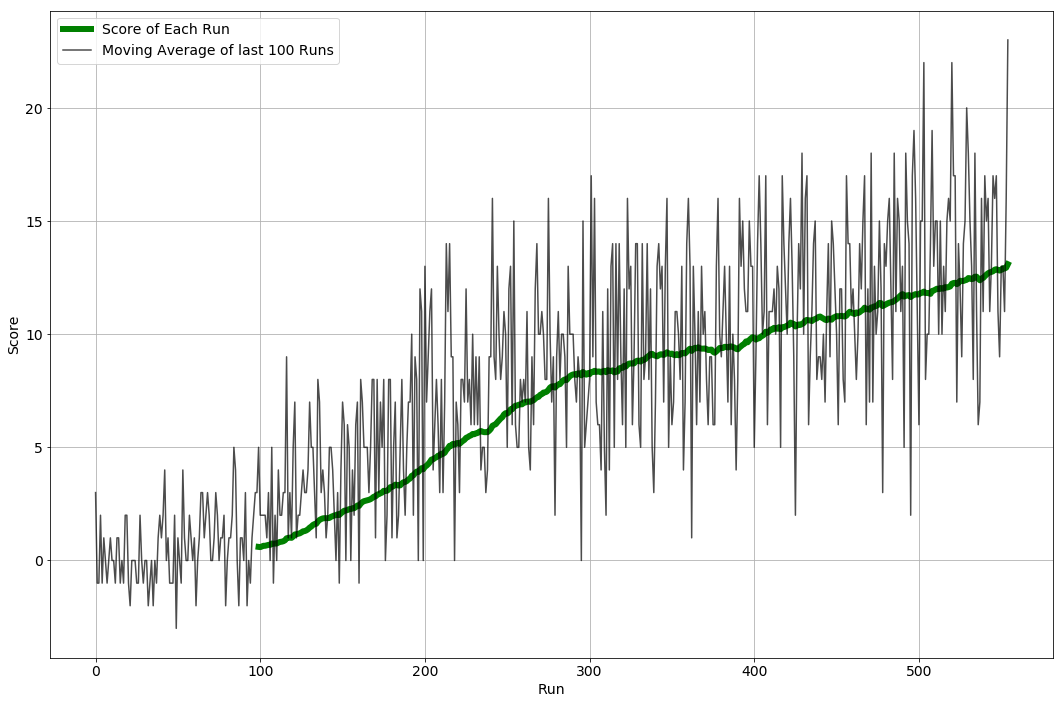

In [20]:
fig, ax = plt.subplots(1, 1, figsize=[15, 10])

scores_av = pd.Series(scores).rolling(100).mean()
ax.plot(scores_av, "-", c="green", linewidth=6)
ax.plot(scores, "-", c="black", alpha=0.7)
ax.set_xlabel("Run")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.legend(["Score of Each Run", "Moving Average of last 100 Runs", "Criteria"])
fig.tight_layout()
fig.savefig("result_score.jpg")

### 6. Watch a Smart Agent!
In the next code cell, you will load the trained weights from file to watch a smart agent!

In [13]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]   # get the next state
    
    for j in range(200):
        action = agent.act(state).astype(int)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]   # get the next state
        done = env_info.local_done[0]                  # see if episode has finished
        if done:
            break 

When finished, you can close the environment.

In [ ]:
env.close()